In [1]:

from bokeh.plotting import figure, show
from bokeh.palettes import Turbo256
from bokeh.models import ColumnDataSource, HoverTool, ColorBar, LinearColorMapper
import plotly.express as px
import numpy as np
import pandas as pd
from bokeh.io import output_notebook
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

output_notebook()

def embedding_plotter(embedding, data=None, hue=None, hover=None):
    '''
    Рисовалка эмбеддинга. 2D renderer: bokeh. 3D renderer: plotly.
    '''
    if embedding.shape[1] not in [2, 3]:
        raise ValueError("Embedding must be 2D or 3D")

    plot_data = pd.DataFrame()
    plot_data['x'] = embedding[:, 0]
    plot_data['y'] = embedding[:, 1]

    if embedding.shape[1] == 3:
        plot_data['z'] = embedding[:, 2]

    if hover is not None:
        if isinstance(hover, str):
            hover = [hover]
        for col in hover:
            if data is not None:
                plot_data[col] = data[col].values

    if embedding.shape[1] == 2:
        p = figure(width=800, height=600, tools=['pan', 'box_zoom', 'reset'])

        if hue is not None and data is not None:
            # Непрерывная цветовая палитра
            color_mapper = LinearColorMapper(palette=Turbo256,
                                          low=data[hue].min(),
                                          high=data[hue].max())

            source = ColumnDataSource({
                'x': plot_data['x'],
                'y': plot_data['y'],
                'hue': data[hue]
            })

            if hover:
                for col in hover:
                    source.data[col] = data[col].values

            p.scatter('x', 'y',
                     source=source,
                     size=8,
                     color={'field': 'hue', 'transform': color_mapper},
                     alpha=0.6)

            color_bar = ColorBar(color_mapper=color_mapper,
                               label_standoff=12,
                               title=hue)
            p.add_layout(color_bar, 'right')

            if hover:
                tooltips = [(col, '@' + col) for col in hover]
                tooltips.append((hue, '@hue'))
                hover_tool = HoverTool(tooltips=tooltips)
                p.add_tools(hover_tool)

        else:
            p.scatter(plot_data['x'], plot_data['y'], size=8, alpha=0.6)

            if hover:
                tooltips = [(col, '@' + col) for col in hover]
                hover_tool = HoverTool(tooltips=tooltips)
                p.add_tools(hover_tool)

        show(p)

    # 3D
    else:
        if hue is not None and data is not None:
            fig = px.scatter_3d(plot_data, x='x', y='y', z='z',
                              color=data[hue],
                              hover_data=hover if hover else None)
        else:
            fig = px.scatter_3d(plot_data, x='x', y='y', z='z',
                              hover_data=hover if hover else None)

        fig.update_layout(
            width=800,
            height=600,
        )


        fig.show()
def representative_point_idx(df):
        points = df.select(pl.col("X", "Y")).to_numpy()
        median = hdm.geomedian(points, axis = 0)
        dists = np.linalg.norm(points - median, axis=1)
        return np.argmin(dists)
import sklearn.cluster as clu

from IPython.display import display, HTML

Loading BokehJS ...

To generate UMAP files from `hexanes_rwp5_constr.cor` run

``` 
 rmsd-map-distances -o hexanes_rwp5_constr hexanes_rwp5_constr.cor
 rmsd-map-umaps -o hexanes_rwp5_constr_umaps hexanes_rwp5_constr.npz
 rmsd-map-umaps -d -o hexanes_rwp5_constr_umaps_d hexanes_rwp5_constr.npz
```

In [2]:
# !rmsd-map-distances -o ./cl/cl_constr ./cl/clcl.cor

In [3]:
# !rmsd-map-umaps -o ./cl/cl_constr_umaps ./cl/cl_constr.npz
# !rmsd-map-umaps -d -o ./cl/cl_constr_umaps_d ./cl/cl_constr.npz

<Axes: xlabel='X', ylabel='Y'>

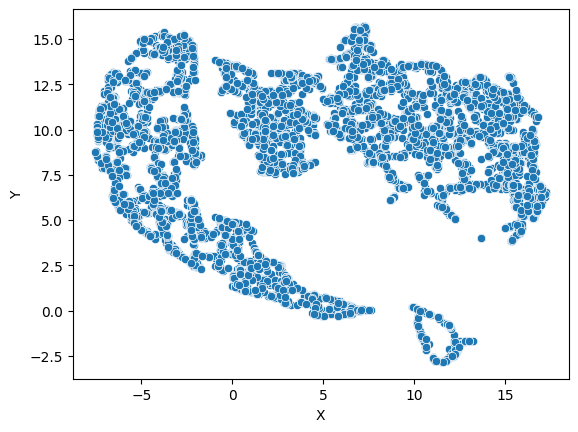

In [4]:
import rmsd_map
from rmsd_map.mol_io.cor_reader import read_cor_file
from rmsd_map.mol_io.fragment import Fragment
from rmsd_map.rmsd.pipelines import align_fragments
import numpy as np
import polars as pl
import seaborn as sns
cor = read_cor_file("./cl/clcl.cor")
cor = np.asarray(cor, dtype=object)
um = pl.read_csv("./cl/cl_constr_umaps.csv") # Vanilla UMAP
ud = pl.read_csv("./cl/cl_constr_umaps_d.csv") # Denity-preserving UMAP 



df = ud.filter(pl.col("N") == 6)
sns.scatterplot(data = df , x="X", y="Y")

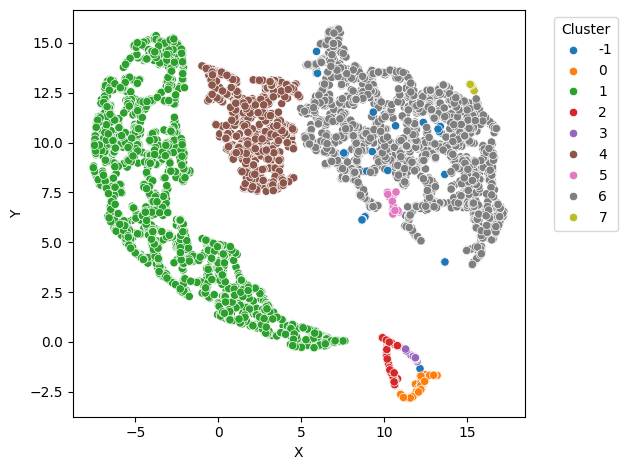

In [5]:

import sklearn.cluster as clu
import matplotlib.pyplot as plt

dbscan = clu.HDBSCAN(min_cluster_size=15,
    min_samples=5,
    cluster_selection_epsilon=0.4,
    metric='euclidean').fit(df.select(pl.col("X", "Y")).to_numpy())
df2 = df.with_columns(pl.Series("label", dbscan.labels_))

sns.scatterplot(data = df2, x = 'X', y = 'Y', hue = 'label', palette='tab10')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [6]:
import scipy
values = []
for x in cor:
    # print(x.coords[1])
    values.append(float(scipy.spatial.distance.euclidean(np.array(x.coords[1]), np.array(x.coords[2]))))
values[0], cor[0]

(3.411013603210449,
 Fragment(id='BAHVAL_1', elements=array(['C', 'Cl', 'Cl', 'C'], dtype='<U2'), coords=array([[ 6.64924,  5.51665,  1.69505],
        [ 7.7865 ,  5.80047,  0.43667],
        [10.30164,  7.93269, -0.43667],
        [11.4389 ,  8.21651, -1.69505]], dtype=float32)))

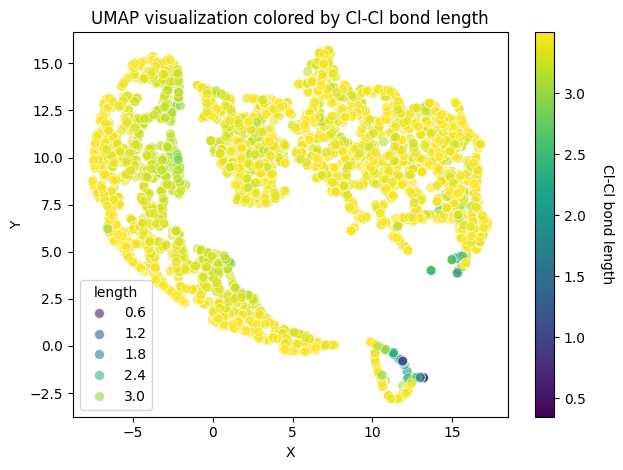

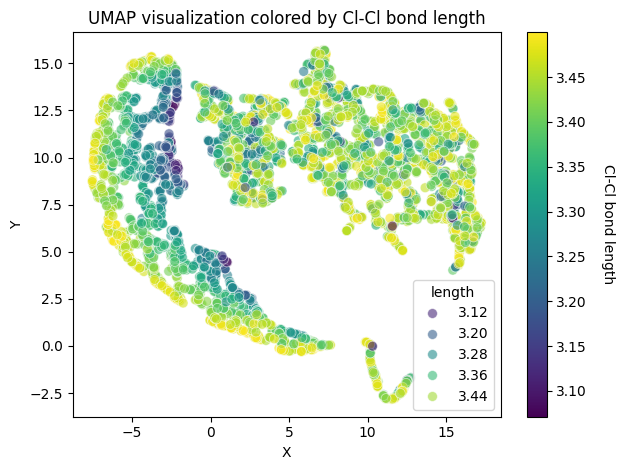

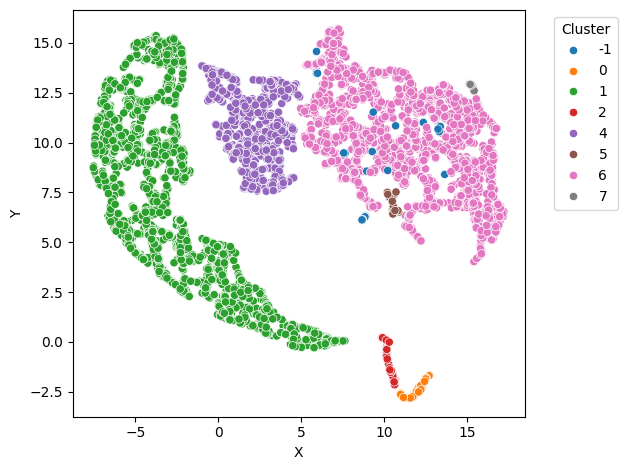

In [7]:
df3 = df2.with_columns(pl.Series('length', values))

# Use continuous colormap for bond lengths (viridis is a good default for continuous data)
scatter = sns.scatterplot(data = df3, x = 'X', y = 'Y', hue = 'length', 
                         palette='viridis', s=50, alpha=0.6)
# Get the colorbar from the scatter plot
norm = plt.Normalize(df3['length'].min(), df3['length'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Cl-Cl bond length', rotation=270, labelpad=20)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('UMAP visualization colored by Cl-Cl bond length')
plt.tight_layout()
plt.show()


# Use continuous colormap for bond lengths (viridis is a good default for continuous data)
df4 = df3.filter(df3['length'] >= 3.07)
scatter = sns.scatterplot(data = df4, x = 'X', y = 'Y', hue = 'length', 
                         palette='viridis', s=50, alpha=0.6)
# Get the colorbar from the scatter plot
norm = plt.Normalize(df4['length'].min(), df4['length'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Cl-Cl bond length', rotation=270, labelpad=20)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('UMAP visualization colored by Cl-Cl bond length')
plt.tight_layout()
plt.show()



sns.scatterplot(data = df4, x = 'X', y = 'Y', hue = 'label', palette='tab10')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

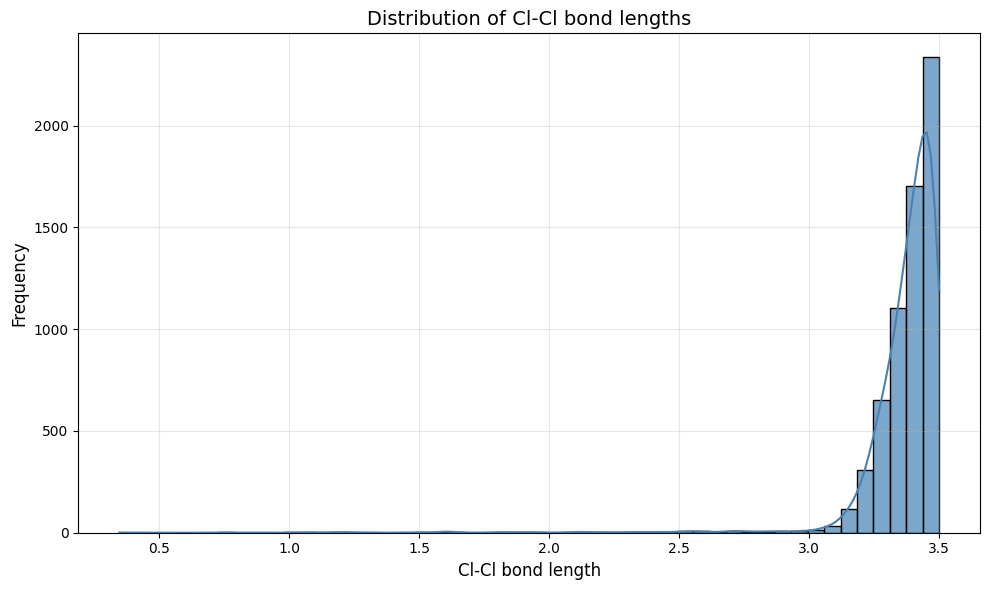

Mean: 3.3708
Median: 3.4088
Std: 0.1926
Min: 0.3476
Max: 3.5000


In [8]:
# Plot distribution of Cl-Cl bond lengths
plt.figure(figsize=(10, 6))
sns.histplot(data=df3, x='length', bins=50, kde=True, color='steelblue', alpha=0.7)
plt.xlabel('Cl-Cl bond length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Cl-Cl bond lengths', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Mean: {df3['length'].mean():.4f}")
print(f"Median: {df3['length'].median():.4f}")
print(f"Std: {df3['length'].std():.4f}")
print(f"Min: {df3['length'].min():.4f}")
print(f"Max: {df3['length'].max():.4f}")


In [9]:
for i in df3["label"].unique():
    # Convert Polars boolean Series to numpy array for indexing
    # Need parentheses to ensure correct operator precedence: & has higher precedence than ==
    mask = ((df3["label"] == i) & (df3['length'] >= 3.07)).to_numpy()
    clu0_all = cor[mask]
    
    # Skip if no fragments match the filter
    if len(clu0_all) == 0:
        print(f'Cluster {i} has 0 fragments (no fragments with length >= 3.07)')
        continue
    
    # Sample 100 elements (or all if less than 100)
    n_samples = min(100, len(clu0_all))
    # print(clu0_all)
    if n_samples > 0 and len(clu0_all) > 0:
        sample_indices = np.random.choice(len(clu0_all), size=n_samples, replace=False)
        clu0 = clu0_all[sample_indices]
    else:
        clu0 = clu0_all
    clu0_center_idx = 0 # find a central point on umap
    clu0_aligned = align_fragments(clu0, clu0_center_idx) # and align all fragments to it
    # print(clu0_aligned)
    print(f'Cluster {i} has {len(clu0_aligned)} fragments (sampled from {len(clu0_all)})')
    clu0_view = Fragment.plot_fragments(clu0_aligned)
    display(HTML(clu0_view.write_html(fullpage=True)))



Cluster -1 has 28 fragments (sampled from 28)


Cluster 0 has 91 fragments (sampled from 91)


Cluster 1 has 100 fragments (sampled from 2355)


Cluster 2 has 87 fragments (sampled from 87)


Cluster 3 has 0 fragments (no fragments with length >= 3.07)
Cluster 4 has 100 fragments (sampled from 971)


Cluster 5 has 43 fragments (sampled from 43)


Cluster 6 has 100 fragments (sampled from 2653)


Cluster 7 has 20 fragments (sampled from 20)


In [10]:
for i in df2["label"].unique():
    # Convert Polars boolean Series to numpy array for indexing
    mask = (df2["label"] == i && df2['length'] >= 3.07).to_numpy()
    clu0_all = cor[mask]
    # Sample 100 elements (or all if less than 100)
    n_samples = min(100, len(clu0_all))
    # print(clu0_all)
    if n_samples > 0 and len(clu0_all) > 0:
        sample_indices = np.random.choice(len(clu0_all), size=n_samples, replace=False)
        clu0 = clu0_all[sample_indices]
    else:
        clu0 = clu0_all
    clu0_center_idx = 0 # find a central point on umap
    clu0_aligned = align_fragments(clu0, clu0_center_idx) # and align all fragments to it
    # print(clu0_aligned)
    print(f'Cluster {i} has {len(clu0_aligned)} fragments (sampled from {len(clu0_all)})')
    clu0_view = Fragment.plot_fragments(clu0_aligned)
    display(HTML(clu0_view.write_html(fullpage=True)))


SyntaxError: invalid syntax (1093493190.py, line 3)